# DRAW

### References:
- [tf implementation](https://github.com/ericjang/draw)
- [paper](https://arxiv.org/pdf/1502.04623.pdf)
- [paper review](https://github.com/tensorflow/magenta/blob/master/magenta/reviews/draw.md)


In [1]:
from read_mnist import read_images, read_labels
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
import os

BATCH_SIZE = 32

In [2]:
def load_dataset(name):
    def featurize(image):
        return image.astype(float) / 255.0
    images = np.array([featurize(image) for image in read_images(name + '-images-idx3-ubyte')])
    labels = np.array([label for label in read_labels(name + '-labels-idx1-ubyte')])
    return images, labels

test_in, test_out = load_dataset('../data/t10k')
train_in, train_out = load_dataset('../data/train')

In [3]:
# train_image = tf.convert_to_tensor(train_in)
# train_label = tf.convert_to_tensor(train_out)
# image_q, label_q = tf.train.slice_input_producer([train_image, train_label], num_epochs=None, shuffle=True)
# image_batch, label_batch = tf.train.shuffle_batch([image_q, label_q], batch_size=BATCH_SIZE, capacity=512, min_after_dequeue=256)


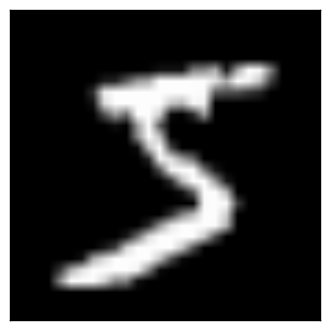

In [4]:
%matplotlib inline
imshow_multi([train_in[0]])


In [5]:
def weight_var(shape, stddev=0.1, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    v = tf.Variable(initial, name=name)
    return v

def create_fc(x, out_size):
    w = tf.get_variable("w", [x.get_shape()[1], out_size], initializer=tf.contrib.layers.xavier_initializer()) 
    b = tf.get_variable("b", [out_size], initializer=tf.constant_initializer(0.0))
    return tf.nn.elu(tf.matmul(x, w) + b)


def create_linear(x, out_size):
    w = tf.get_variable("w", [x.get_shape()[1], out_size], initializer=tf.contrib.layers.xavier_initializer()) 
    b = tf.get_variable("b", [out_size], initializer=tf.constant_initializer(0.0))
    return tf.matmul(x, w) + b



In [6]:
Z_SIZE = 2
LSTM_SIZE = 256
STEPS = 5
IMG_SIZE = 28
BATCH_SIZE = 100
EPS = 1e-8

image = tf.placeholder(tf.float32, [None, IMG_SIZE, IMG_SIZE], name='image')

# when generating images, still need to fill the `image` placeholder with zeros
generate_images = tf.placeholder_with_default(tf.constant(0.0), [], name='generate_images')

def read_without_attention(target_image, current_canvas, prev_decoder_state):
    # when we add attention, the decoder gets to "ask" where to attend to in the image
    flat_img_shape = [-1, IMG_SIZE * IMG_SIZE]
    return tf.concat(1, [tf.reshape(target_image, flat_img_shape), tf.reshape(current_canvas, flat_img_shape)])

def write_without_attention(canvas, h_dec, reuse):
    with tf.variable_scope('write', reuse=reuse):
        write = create_linear(h_dec, IMG_SIZE * IMG_SIZE)
        write = tf.reshape(write, [-1, IMG_SIZE, IMG_SIZE])
    return canvas + write

def encoder(read_data, enc_state, reuse_vars):
    with tf.variable_scope('encoder', reuse=reuse_vars):
        h_enc, enc_state = encoder_lstm(read_data, enc_state)
        return h_enc, enc_state

def sample_z(z_mean, z_stddev):
    rand = tf.random_normal(tf.shape(z_stddev), 0, 1, dtype=tf.float32)
    return z_mean + rand * z_stddev

def decoder(z, dec_state, reuse_vars):
    # returns a new draw operation
    with tf.variable_scope('decoder', reuse=reuse_vars):
        h_dec, dec_state = decoder_lstm(z, dec_state)
        return h_dec, dec_state

encoder_lstm = tf.nn.rnn_cell.LSTMCell(LSTM_SIZE, state_is_tuple=True)
decoder_lstm = tf.nn.rnn_cell.LSTMCell(LSTM_SIZE, state_is_tuple=True)

# the paper says we should learn the initial encoder/decoder states, but eric jang's implementation doesn't
enc_state = encoder_lstm.zero_state(BATCH_SIZE, tf.float32)
dec_state = decoder_lstm.zero_state(BATCH_SIZE, tf.float32)

z_means = []
z_log_sigmas = []
canvases = [tf.zeros_like(image)] # canvas = c[t], in the paper

for step in xrange(STEPS):
    reuse = step > 0
    
    error_image = image - canvases[-1] # error_image = x_hat, in the paper; jang's implementation uses the sigmoid of c instead
    read_data = read_without_attention(image, canvases[-1], dec_state) # r_t in paper
    h_enc, enc_state = encoder(read_data, enc_state, reuse)
    
    with tf.variable_scope('z_mean', reuse=reuse):
        z_means.append(create_linear(h_enc, Z_SIZE))
    with tf.variable_scope('z_sigma', reuse=reuse):
        z_log_sigmas.append(create_linear(h_enc, Z_SIZE))
    
    real_z = sample_z(z_means[-1], tf.exp(z_log_sigmas[-1]))
    generated_z = sample_z(tf.random_normal(tf.shape(real_z), 0, 1, dtype=tf.float32), tf.random_normal(tf.shape(real_z), 0, 1, dtype=tf.float32))
    z = real_z * (1 - generate_images) + generated_z * generate_images
    
    h_dec, dec_state = decoder(z, dec_state, step > 0)
    canvases.append(write_without_attention(canvases[-1], h_dec, reuse))

# from http://blog.fastforwardlabs.com/post/149329060653/under-the-hood-of-the-variational-autoencoder-in
# def kullback_leibler(mu, log_sigma):
#     """(Gaussian) Kullback-Leibler divergence KL(q||p), per training example"""
#     with tf.name_scope("KL_divergence"):
#         # = -0.5 * (1 + log(sigma**2) - mu**2 - sigma**2)
#         return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 -
#                                     tf.exp(2 * log_sigma), 1)

def compute_kl_loss(z_means, z_log_sigmas):
    # from https://github.com/ericjang/draw/blob/master/draw.py
    kl_terms=[0]*STEPS
    for t in range(STEPS):
        mu2=tf.square(z_means[t])
        sigma2=tf.square(tf.exp(z_log_sigmas[t]))
        logsigma=z_log_sigmas[t]
        kl_terms[t]=0.5*tf.reduce_sum(mu2+sigma2-2*logsigma,1)-STEPS*.5 # each kl term is (1xminibatch)
    KL=tf.add_n(kl_terms) # this is 1xminibatch, corresponding to summing kl_terms from 1:T
    Lz=tf.reduce_mean(KL) # average over minibatches
    return Lz
    
# image loss:
def binary_crossentropy(t,o):
    # from https://github.com/ericjang/draw/blob/master/draw.py
    return -(t*tf.log(o+EPS) + (1.0-t)*tf.log(1.0-o+EPS))

recons = tf.nn.sigmoid(canvases[-1])
binarized_image = tf.round(image)
image_loss_per_image = tf.reduce_sum(binary_crossentropy(binarized_image, recons))
image_loss = tf.reduce_mean(image_loss_per_image)

# KL divergence:
z_means_tf = tf.pack(z_means)
z_log_sigmas_tf = tf.pack(z_log_sigmas)
# kl_loss = tf.reduce_mean(kullback_leibler(z_means_tf, z_log_sigmas_tf))
kl_loss = compute_kl_loss(z_means_tf, z_log_sigmas_tf)

# loss = image_loss + kl_loss * 0.0001
loss = image_loss + kl_loss

session = tf.InteractiveSession()

canvases_tf = tf.pack(canvases)

learn_rate = tf.placeholder(tf.float32, name='learning_rate')
optimizer = tf.train.AdamOptimizer(learn_rate)
global_step = tf.contrib.framework.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)

session.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
tf.train.start_queue_runners()


[]

In [7]:
# for v in tf.all_variables():
#   print "%s : %s" % (v.name,v.get_shape())

In [8]:
def random_batch(inputs):
    indices = np.random.randint(0, len(inputs)-1, BATCH_SIZE)
    return inputs.take(indices, axis=0)

In [9]:
losses = []

while True:
    inputs = random_batch(train_in)
    feed = {image: np.array(inputs), learn_rate: 0.01}
    _, step_, loss_, il_, kl_ = session.run([train_step, global_step, loss, image_loss, kl_loss], feed_dict=feed)
    losses.append(loss_)
    if step_ % 400 == 1:
        print "Step: {}, loss: {}, {}+{}".format(step_, sum(losses) / len(losses), il_, kl_)
        losses = []



Step: 1, loss: 54390.6523438, 54397.828125+-7.17723560333
Step: 401, loss: 15539.1564502, 11356.2119141+44.2380485535
Step: 801, loss: 10737.9556616, 9954.27539062+46.7574691772
Step: 1201, loss: 9460.81701172, 8516.40039062+41.4191894531
Step: 1601, loss: 8899.96064819, 8663.578125+50.0029563904
Step: 2001, loss: 8495.65726807, 8797.62011719+47.783203125
Step: 2401, loss: 8265.23181763, 8289.66015625+45.9290771484


KeyboardInterrupt: 

Original and final images:


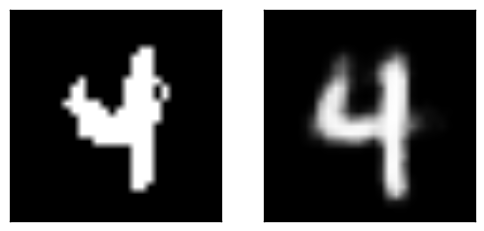

Drawing steps:


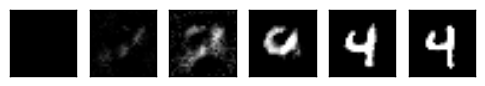

In [13]:
%matplotlib inline

# Visualize the reconstruction of sample digits:

if True:
    inputs = random_batch(train_in)
    image_, recons_, canvases_ = session.run([binarized_image, recons, canvases_tf], feed_dict={image: np.array(inputs)})
    # imshow_multi([image_[0], recons_[0]])
    print "Original and final images:"
    imshow_multi([image_[0], recons_[0]])
    print "Drawing steps:"
    imshow_multi(canvases_[:,0])


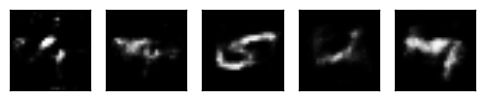

In [19]:
%matplotlib inline

# Random generation:
if True:
    images_zero = np.zeros_like(np.array(random_batch(train_in)))
    images_ = session.run(recons, feed_dict={image: images_zero, generate_images: 1})
    imshow_multi(images_[:5])